In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
%matplotlib inline
tf.__version__

'2.4.1'

In [2]:
INPUT_SHAPE = (192, 192, 3)
epochs = 10
batch_size = 32
valratio = 0.15

In [3]:
train_path = 'HACKATHON/images/train/'
test_path = 'HACKATHON/images/test/'

label_path = 'HACKATHON/train.txt'

In [4]:
ss = []
with open(label_path, 'r') as f:
    for row in f:
        ss.append(row)

In [5]:
len(os.listdir(train_path))

355

In [6]:
def loadnib(path, root = train_path):
    scan = nib.load(train_path+ path)
    return np.array(scan.dataobj)

In [7]:
img = loadnib('0657.nii.gz')
img.shape, img[0].shape

((512, 512, 66), (512, 66))

In [8]:
def nibtoimg(path, root = train_path, slc = 25, file = 't.jpeg'):
    scan = nib.load(train_path+ path)
    scan = np.array(scan.dataobj)
    t = np.rot90(scan[:,:,slc], k=3)
    matplotlib.image.imsave(file, t)

In [9]:
def plot_slice(img, slc):
    #plt.title("CT slika, slice %s:",slc)
    plt.imshow(np.rot90(img[:,:,slc], k=3),cmap='gray')

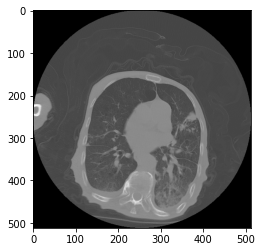

In [10]:
plot_slice(img, 34)

In [11]:
labels = []
for k in sorted(ss):
    a,b = k.split(',')
    labels.append(int(b))

In [12]:
labels = np.array(labels)
labels.shape

(355,)

In [57]:
def save_img(img, path = 'output.jpeg', grey = True):
    plt.imsave(path, img, cmap = 'gray')

In [14]:
import matplotlib

matplotlib.image.imsave('name.png', np.rot90(img[:,:,10], k=3))

In [115]:
from PIL import Image
def rgb_loader(path):
    img = Image.open(path)
    return img.convert('RGB')

In [16]:
transform = transforms.Compose([
            transforms.Resize((350, 350)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])

In [17]:
f = transform(rgb_loader('name.png'))
t = torch.reshape(f, (f.shape[1],f.shape[2], f.shape[0]))

In [18]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input, Sequential

In [19]:
def gen(path = train_path):
    for filepath in os.listdir(path):
        try:
            scan = nib.load(path+filepath)
            yield np.array(scan.dataobj)
        except StopIteration:
            break;

In [20]:
g = gen()
n = next(g)
n.shape

(512, 512, 62)

In [21]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model_lung_infection.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']),map_location=torch.device('cpu') )
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=True, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        # Please replace it with your custom path
        model_state = torch.load('res2net50_v1b_26w_4s-3cf99910.pth', map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # model_lung_infection.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel, n_class):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, n_class, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class Inf_Net(nn.Module):
    def __init__(self, channel=32, n_class=1):
        super(Inf_Net, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)

        # ---- Partial Decoder ----
        self.ParDec = aggregation(channel, n_class)

        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256+64, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, n_class, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

        # ---- edge branch ----
        self.edge_conv1 = BasicConv2d(256, 64, kernel_size=1)
        self.edge_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        # ---- low-level features ----
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88

        # ---- high-level features ----
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44
        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        # ---- edge guidance ----
        x = self.edge_conv1(x1)
        x = self.edge_conv2(x)
        edge_guidance = self.edge_conv3(x)  # torch.Size([1, 64, 88, 88])
        lateral_edge = self.edge_conv4(edge_guidance)   # NOTES: Sup-2 (bs, 1, 88, 88) -> (bs, 1, 352, 352)
        lateral_edge = F.interpolate(lateral_edge,
                                     scale_factor=4,
                                     mode='bilinear')

        # ---- global guidance ----
        ra5_feat = self.ParDec(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat,
                                      scale_factor=8,
                                      mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1  # reverse
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = torch.cat((self.ra4_conv1(x), F.interpolate(edge_guidance, scale_factor=1/8, mode='bilinear')), dim=1)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4   # element-wise addition
        lateral_map_4 = F.interpolate(x,
                                      scale_factor=32,
                                      mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = torch.cat((self.ra3_conv1(x), F.interpolate(edge_guidance, scale_factor=1/4, mode='bilinear')), dim=1)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x,
                                      scale_factor=16,
                                      mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = torch.cat((self.ra2_conv1(x), F.interpolate(edge_guidance, scale_factor=1/2, mode='bilinear')), dim=1)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x,
                                      scale_factor=8,
                                      mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge


In [25]:
snapshot_dir = 'Inf-Net-100.pth'

In [26]:
infnet = Inf_Net()
device = torch.device('cpu')
infnet.load_state_dict(torch.load(snapshot_dir, map_location=device))

FileNotFoundError: [Errno 2] No such file or directory: 'Inf-Net-100.pth'

In [27]:
print("You mothafucka")

You mothafucka


In [28]:
act = tf.nn.leaky_relu
INPUT_SHAPE = (1,12,350,350,1)

In [29]:
n = next(g)
n.shape

(512, 512, 73)

In [30]:
### n_channels, n_classes, image_W, image_H

In [31]:
#for name, param in model.named_parameters():
    #if param.requires_grad:
        #print(name, param.data)

## inf net

In [32]:
source_pth = 'Inf-Net/Inf-Net-100.pth   '

In [33]:
nibtoimg('0656.nii.gz', slc = 22)

In [192]:
import cv2
from PIL import Image

k = 'name.jpeg'
img = Image.open(k)
img = img.convert('RGB')

def transform(x):
    #x = torch.Tensor(x)
    operation = transforms.Compose([
                transforms.Resize((352, 352)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
    ])
    return operation(x).unsqueeze(0)

In [193]:
t = transform(img)
t.shape

torch.Size([1, 3, 352, 352])

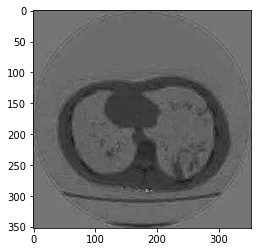

In [194]:
plt.imshow(t[0][0], cmap='gray')

In [195]:
plt.imsave('name.jpeg', t[0][0], cmap='gray')

In [196]:
k = torch.Tensor(t)
#output, a,b,c,d = infnet(k)
#output[0].shape

In [40]:
from scipy import misc
lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = model(k)
res = lateral_map_2
res = res.sigmoid().data.cpu().numpy().squeeze()
res = (res - res.min()) / (res.max() - res.min() + 1e-8)
plt.imshow(res, cmap='gray')

NameError: name 'model' is not defined

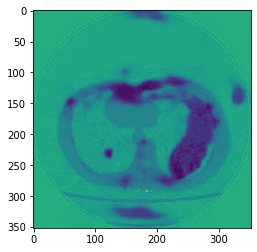

In [271]:
r = t[0][0] -res
plt.imshow(r)

## Semi Inf-Net

In [51]:
!mkdir -p Results/Lung-infection-segmentation/Semi-Inf-Net/

In [52]:
save_path = 'Results/Lung-infection-segmentation/Semi-Inf-Net/'

In [53]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model_lung_infection.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']),map_location=torch.device('cpu') )
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=True, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        # Please replace it with your custom path
        model_state = torch.load('res2net50_v1b_26w_4s-3cf99910.pth', map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # model_lung_infection.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel, n_class):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, n_class, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class Inf_Net(nn.Module):
    def __init__(self, channel=32, n_class=1):
        super(Inf_Net, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)

        # ---- Partial Decoder ----
        self.ParDec = aggregation(channel, n_class)

        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256+64, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, n_class, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

        # ---- edge branch ----
        self.edge_conv1 = BasicConv2d(256, 64, kernel_size=1)
        self.edge_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        # ---- low-level features ----
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88

        # ---- high-level features ----
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44
        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        # ---- edge guidance ----
        x = self.edge_conv1(x1)
        x = self.edge_conv2(x)
        edge_guidance = self.edge_conv3(x)  # torch.Size([1, 64, 88, 88])
        lateral_edge = self.edge_conv4(edge_guidance)   # NOTES: Sup-2 (bs, 1, 88, 88) -> (bs, 1, 352, 352)
        lateral_edge = F.interpolate(lateral_edge,
                                     scale_factor=4,
                                     mode='bilinear')

        # ---- global guidance ----
        ra5_feat = self.ParDec(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat,
                                      scale_factor=8,
                                      mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1  # reverse
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = torch.cat((self.ra4_conv1(x), F.interpolate(edge_guidance, scale_factor=1/8, mode='bilinear')), dim=1)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4   # element-wise addition
        lateral_map_4 = F.interpolate(x,
                                      scale_factor=32,
                                      mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = torch.cat((self.ra3_conv1(x), F.interpolate(edge_guidance, scale_factor=1/4, mode='bilinear')), dim=1)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x,
                                      scale_factor=16,
                                      mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = torch.cat((self.ra2_conv1(x), F.interpolate(edge_guidance, scale_factor=1/2, mode='bilinear')), dim=1)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x,
                                      scale_factor=8,
                                      mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge


In [188]:
seminet_pth ='Semi-Inf-Net-100.pth'

In [189]:
semi = Inf_Net()
device = torch.device('cpu')
semi.load_state_dict(torch.load(seminet_pth, map_location=device))

<All keys matched successfully>

In [79]:
def predict_plot(k, model = infnet):
    lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = model(k)
    res = lateral_map_2
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    plt.imsave(save_path + '0.jpeg' ,res, cmap = 'gray')
    plt.imshow(res, cmap='gray')

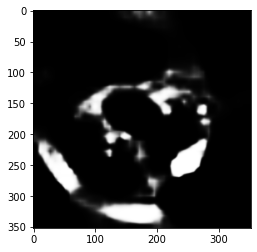

In [67]:
predict_plot(k)

In [197]:
lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = semi(k)

In [198]:
res = lateral_map_2
res = res.sigmoid().data.cpu().numpy().squeeze()
res = (res - res.min()) / (res.max() - res.min() + 1e-8)
res.shape

(352, 352)

In [200]:
plt.imsave('pseudo.jpeg', res)

## Semi Unet

In [201]:
path = 'Semi-Inf-Net_UNet/unet_model_200.pkl'

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [203]:
class Inf_Net_UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Inf_Net_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [204]:
infnet = Inf_Net_UNet(6,3)
device = torch.device('cpu')
infnet.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [119]:
def transform(x):
    #x = torch.Tensor(x)
    operation = transforms.Compose([
                transforms.Resize((352, 352)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
    ])
    return operation(x).unsqueeze(0)

In [120]:
plt.imsave('pseudo.jpeg', pseudo.detach().numpy())

In [205]:
img = 'name.jpeg'
img = Image.open(img)
img = img.convert('RGB')
k = transform(img)

In [206]:
img = 'pseudo.jpeg'
img = Image.open(img)
img = img.convert('RGB')
d = transform(img)

In [207]:
k.shape, d.shape

(torch.Size([1, 3, 352, 352]), torch.Size([1, 3, 352, 352]))

In [211]:
s = torch.cat((k,d), dim=1)
s.shape

torch.Size([1, 6, 352, 352])

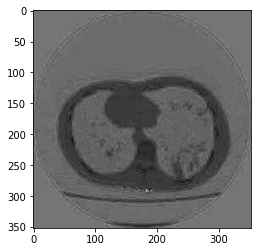

In [212]:
plt.imshow(k[0][0], cmap = 'gray')

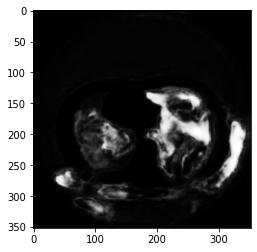

In [219]:
res = infnet(s)
res = torch.sigmoid(res) 
arr = res.detach().numpy()
plt.imshow(arr[0][1], cmap = 'gray')

In [214]:
b, _, w, h = res.size()

# output b*n_class*h*w -- > b*h*w
pred = res.cpu().permute(0, 2, 3, 1).contiguous().view(-1, 3).max(1)[1].view(b, w, h).numpy().squeeze()

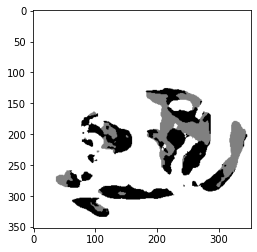

In [215]:
plt.imshow(pred, cmap = 'gray')

In [218]:
## make code functional, jupyterlab zavihki, da lahko numpy, in končna segmentacija(summa)